# STAT226 HW1

Seokjun Choi

*All code blocks are python 3 scripts. All scripts are tested under Python 3.10.5 for 64-bit Windows.*
*Third-party Dependency: numpy, scipy, matplotlib.*


## Question 3 and 4

I will show the covariance function, the semivariogram, and a realized sample path sequentially, for each covariance structure.
The class *IsotropicCovBase* defines all functions that will be shared for all covariance structures.

In [1]:
from math import exp, sin, gamma
from random import seed

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import kv

class IsotropicCovBase:
    def __init__(self, scale_sigma2: float, range_phi: float):
        self.sigma2 = scale_sigma2
        self.phi = range_phi
        self.pseudo_rv_generator = np.random.default_rng()

    def _check_nonnegative(self, dist):
        if dist<0:
            raise ValueError("dist should be nonnegative.")

    def covariance_function(self, dist):
        pass
    
    def semi_variogram(self, dist):
        pass

    def plot_covariance(self, start, end, by, show=True):
        grid = np.arange(start, end, by)
        cov_on_grid = []
        for x in grid:
            cov_on_grid.append(self.covariance_function(x))
        plt.plot(grid, cov_on_grid)
        if show:
            plt.show()

    def plot_semi_variogram(self, start, end, by, show=True):
        grid = np.arange(start, end, by)
        semi_var_on_grid = []
        for x in grid:
            semi_var_on_grid.append(self.semi_variogram(x))
        plt.plot(grid, semi_var_on_grid)
        if show:
            plt.show()

    def _dist_euclidean(self, loc1:list[float], loc2:list[float]):
        if len(loc1)!=len(loc2):
            raise ValueError("the dimensions of two location indices should be the same")
        dist2 = 0
        for s1, s2 in zip(loc1, loc2):
            dist2 += (s1-s2)**2
        return dist2**0.5

    def cov_matrix(self, points, topology="Euclidean"):
        cov_mat = []
        for i in points:
            cov_mat.append([])
            for j in points:
                dist = 0
                if topology == "Euclidean":
                    dist = self._dist_euclidean(i, j)
                else:
                    raise ValueError("now, only Euclidean topology can be used.")
                cov_mat[-1].append(self.covariance_function(dist))
        return np.array(cov_mat)

    def sampler(self, points, topology="Euclidean"):
        cov_mat = self.cov_matrix(points, topology)
        sample = self.pseudo_rv_generator.multivariate_normal(np.zeros(len(points)), cov_mat)
        return sample

To find the *range $\phi$* value making the correlation near 0.05, I would use the 'find_05_phi' function.
I will just pick $\phi$ value giving nearest 0.05 correlation using grid $[0.0001, 5.0000]$ with $0.0001$ unit.
But let me skip showing this procedure for each correlation structure, which is tedious to see.

Then, set $\sigma^2=1$ and a grid that I will draw a sample path.
I use $[0, 0.1, 0.2, ..., 9.9]$ having 100 points here.

In [2]:
# def find_05_phi():
#     for phi in np.arange(0.0001, 5, 0.0001):
#         inst = Wave(1, phi) #<- we can change class here
#         corr_at_1 = inst.covariance_function(1)/inst.covariance_function(0)
#         if corr_at_1>0.05:
#             print(phi, corr_at_1)
#             return phi
# find_05_phi()

seed(20230122)
sigma2 = 1
grid_for_sample = [np.array([i/10]) for i in range(100)]

### Spherical covariance function

Declare the class *Spherical*. The semivariogram can be also calculated by $C(0)-C(x)$ when $C$ is covariance function, 
but I decided to implement it directly to reduce the computational burden.

In [3]:
class Spherical(IsotropicCovBase):
    def covariance_function(self, dist):
        self._check_nonnegative(dist)
        cov = 0
        if dist == 0:
            cov = self.sigma2
        elif dist < self.phi:
            cov = self.sigma2 * (1 - 3*dist / (2*self.phi) + dist**3/(2*self.phi**3))
        else:
            cov = 0
        return cov

    def semi_variogram(self, dist):
        self._check_nonnegative(dist)
        semi_var = 0
        if dist <= self.phi:
            semi_var = self.sigma2 * (3*dist/(2*self.phi) - dist**3/(2*self.phi**3))
        else:
            semi_var = self.sigma2
        return semi_var
   

Under the found $\phi$ making the correlation $0.05$ at dist$=1$, let me draw the covariance function, semivariogram, and one realized sample-path on the grid defined above, in order, respectively.
The printed value on the console shows the correlation value at the distance 1.

0.050021691549989755


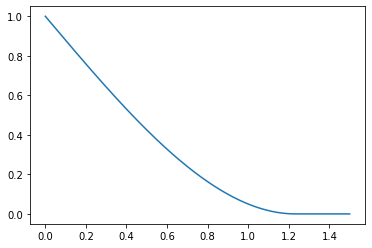

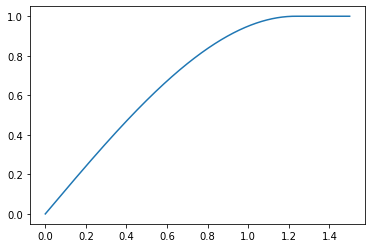

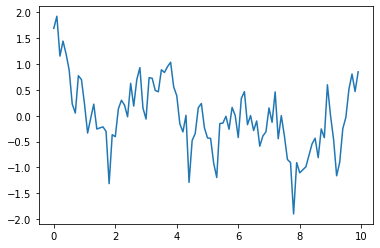

In [4]:
spherical_phi = 1.2325
spherical_inst = Spherical(sigma2, spherical_phi)
print(spherical_inst.covariance_function(1)/spherical_inst.covariance_function(0))
spherical_inst.plot_covariance(0, 1.5, 0.0001)
spherical_inst.plot_semi_variogram(0, 1.5, 0.0001)
spherical_sample = spherical_inst.sampler(grid_for_sample)
plt.plot(grid_for_sample, spherical_sample)
plt.show()

### Powered exponential covariance function

I repeat the above procedure with the powered exponential covariance function.
Let me skip to comment from here.

For additional parameter $\nu$, I set it to $1$.

In [5]:
class PoweredExp(IsotropicCovBase):
    def __init__(self, order_nu: float, scale_sigma2: float, range_phi: float):
        if 0 < order_nu <= 2:
            self.nu = order_nu
        else:
            raise ValueError("It should be 0<nu<=2.")
        super().__init__(scale_sigma2, range_phi)

    def covariance_function(self, dist):
        self._check_nonnegative(dist)
        cov = self.sigma2 * exp(-(abs(dist/self.phi)**self.nu))
        return cov

    def semi_variogram(self, dist):
        self._check_nonnegative(dist)
        semi_var = self.sigma2 * (1 - exp(-(abs(dist/self.phi)**self.nu)))
        return semi_var


0.05004119787673192


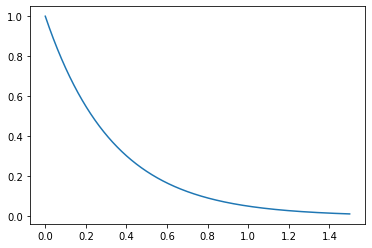

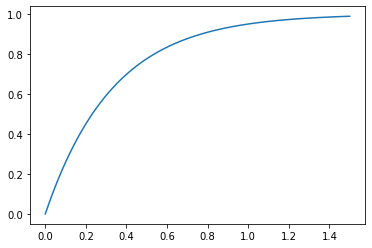

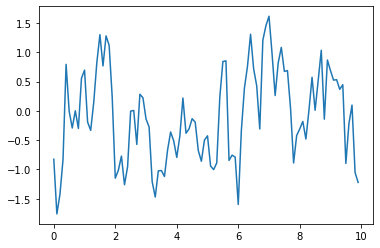

In [6]:
poweredExp_1_phi = 0.3339
poweredExp_1_inst = PoweredExp(1, sigma2, poweredExp_1_phi)
print(poweredExp_1_inst.covariance_function(1)/poweredExp_1_inst.covariance_function(0))
poweredExp_1_inst.plot_covariance(0, 1.5, 0.0001)
poweredExp_1_inst.plot_semi_variogram(0, 1.5, 0.0001)
poweredExp_1_sample = poweredExp_1_inst.sampler(grid_for_sample)
plt.plot(grid_for_sample, poweredExp_1_sample)
plt.show()

### Rational-quadratic covariance function

In [7]:
class RationalQuadratic(IsotropicCovBase):
    def covariance_function(self, dist):
        self._check_nonnegative(dist)
        cov = self.sigma2 * (1 - dist**2/(self.phi**2 + dist**2))
        return cov

    def semi_variogram(self, dist):
        self._check_nonnegative(dist)
        semi_var = self.sigma2*(dist**2) / (self.phi**2 + dist**2)
        return semi_var


0.05003489934288541


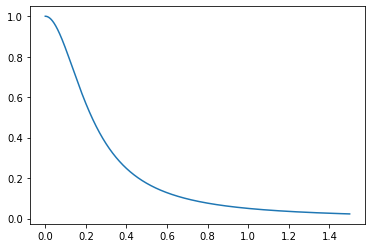

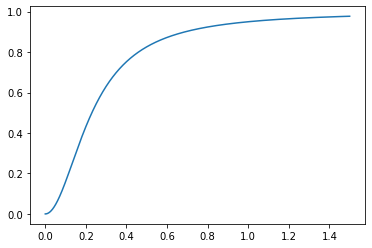

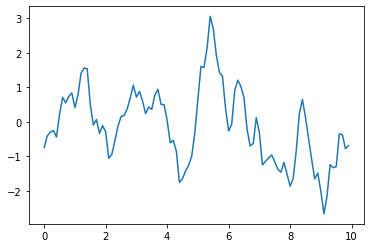

In [8]:
rationalQuadratic_phi = 0.2295
rationalQuadratic_inst = RationalQuadratic(sigma2, rationalQuadratic_phi)
print(rationalQuadratic_inst.covariance_function(1)/rationalQuadratic_inst.covariance_function(0))
rationalQuadratic_inst.plot_covariance(0, 1.5, 0.0001)
rationalQuadratic_inst.plot_semi_variogram(0, 1.5, 0.0001)
rationalQuadratic_sample = rationalQuadratic_inst.sampler(grid_for_sample)
plt.plot(grid_for_sample, rationalQuadratic_sample)
plt.show()

### Wave covariance function

In [9]:
class Wave(IsotropicCovBase):
    def covariance_function(self, dist):
        self._check_nonnegative(dist)
        if dist==0:
            cov = self.sigma2
        else:
            cov = self.sigma2 * sin(dist/self.phi) / (dist/self.phi)
        return cov

    def semi_variogram(self, dist):
        self._check_nonnegative(dist)
        if dist==0:
            semi_var = 0
        else:
            semi_var = self.sigma2 * (1 - sin(dist/self.phi) / (dist/self.phi))
        return semi_var


0.050522165225346194


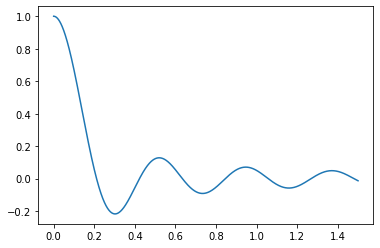

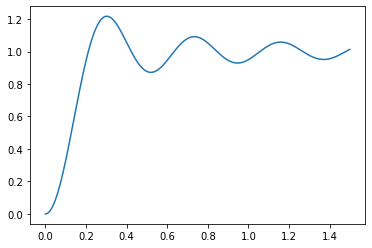

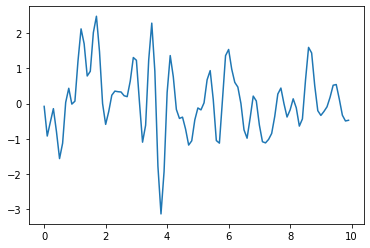

In [10]:
wave_phi = 0.0673
wave_inst = Wave(sigma2, wave_phi)
print(wave_inst.covariance_function(1)/wave_inst.covariance_function(0))
wave_inst.plot_covariance(0, 1.5, 0.0001)
wave_inst.plot_semi_variogram(0, 1.5, 0.0001)
wave_sample = wave_inst.sampler(grid_for_sample)
plt.plot(grid_for_sample, wave_sample)
plt.show()

We can observe that the covariance function has negative values in some parts of the grid!

### Matern covariance function

For the additional parameter $\nu$, I set it to $1$.
It was interesting to compare different $\nu$ s by changing the argument when I made instances (It is super easy to work with using the class below), but let me skip them reporting all here.
I would not like to make this HW report too long.

In [11]:
class Matern(IsotropicCovBase):
    def __init__(self, order_nu: float, scale_sigma2: float, range_phi: float):
        if 0 < order_nu:
            self.nu = order_nu
        else:
            raise ValueError("It should be 0 < nu.")
        super().__init__(scale_sigma2, range_phi)

    def covariance_function(self, dist):
        self._check_nonnegative(dist)
        if dist==0:
            cov = self.sigma2
        else:
            cov = (self.sigma2 / (2**(self.nu-1)*gamma(self.nu))) * ((dist/self.phi)**self.nu) * kv(self.nu, dist/self.phi)
        return cov

    def semi_variogram(self, dist):
        self._check_nonnegative(dist)
        if dist==0:
            semi_var = 0
        else:
            semi_var = self.sigma2 *(1 - (1/(2**(self.nu-1)*gamma(self.nu))) * ((dist/self.phi)**self.nu) * kv(self.nu, dist/self.phi))
        return semi_var

0.0500054385320548


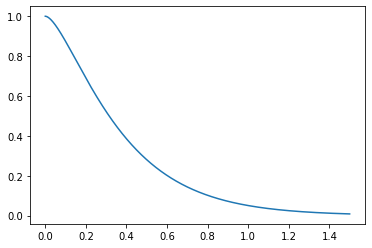

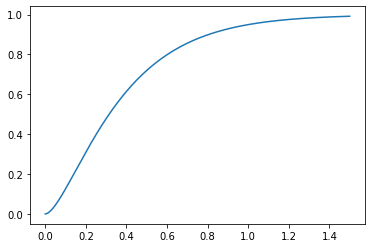

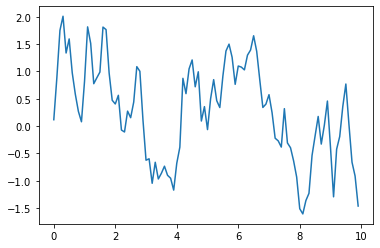

In [12]:
matern_1_phi = 0.2501
matern_1_inst = Matern(1, sigma2, matern_1_phi)
print(matern_1_inst.covariance_function(1)/matern_1_inst.covariance_function(0))
matern_1_inst.plot_covariance(0, 1.5, 0.0001)
matern_1_inst.plot_semi_variogram(0, 1.5, 0.0001)
matern_1_sample = matern_1_inst.sampler(grid_for_sample)
plt.plot(grid_for_sample, matern_1_sample)
plt.show()

### Trouble-observing(?) for the 'RandomFields' package in R

You already mentioned that the depreciated package 'RandomFields' has some problems in the previous class.
When I heard it, I thought that it might be a problem with C(or C++) compiler 'clang' that is already installed on Mac as a default.
So I decided to use GCC instead, as you suggested.

However, I failed to install the package using *RandomFieldsUtils_1.2.5.tar.gz* and *RandomFields_3.3.14.tar.gz* files from the packages' archives (Sanju helped me to find them.)
Cause I'm using a computer with Windows OS, I used MinGW to install GCC and Cmake.
But it seems that the my version of Cmake does not have some commands that are needed to install the 'RandomFieldsUtils*.
So far, I am stuck here.

If you know the way to solve this problem in Windows, please let me know.
Or I may talk with Sanju one more time (She might have succeeded in installing the package on Windows.)

Anyway, so now, let me skip the part 'Repeat using the package RandomFields' in the fourth problem. I will try it later.
